# Кластеризация: DBSCAN

От теории к практике: кластеры произвольной формы, выбор параметров, поиск аномалий

## 1. Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 2. Проблема K-Means: кластеры произвольной формы

📊 Данные: 300 объектов
   Истинные классы: [0 1]


/tmp/ipykernel_54573/3672420034.py:73: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_54573/3672420034.py:73: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/pc-arch-vladg00dman/Projects/RegionPreparing/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pc-arch-vladg00dman/Projects/RegionPreparing/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


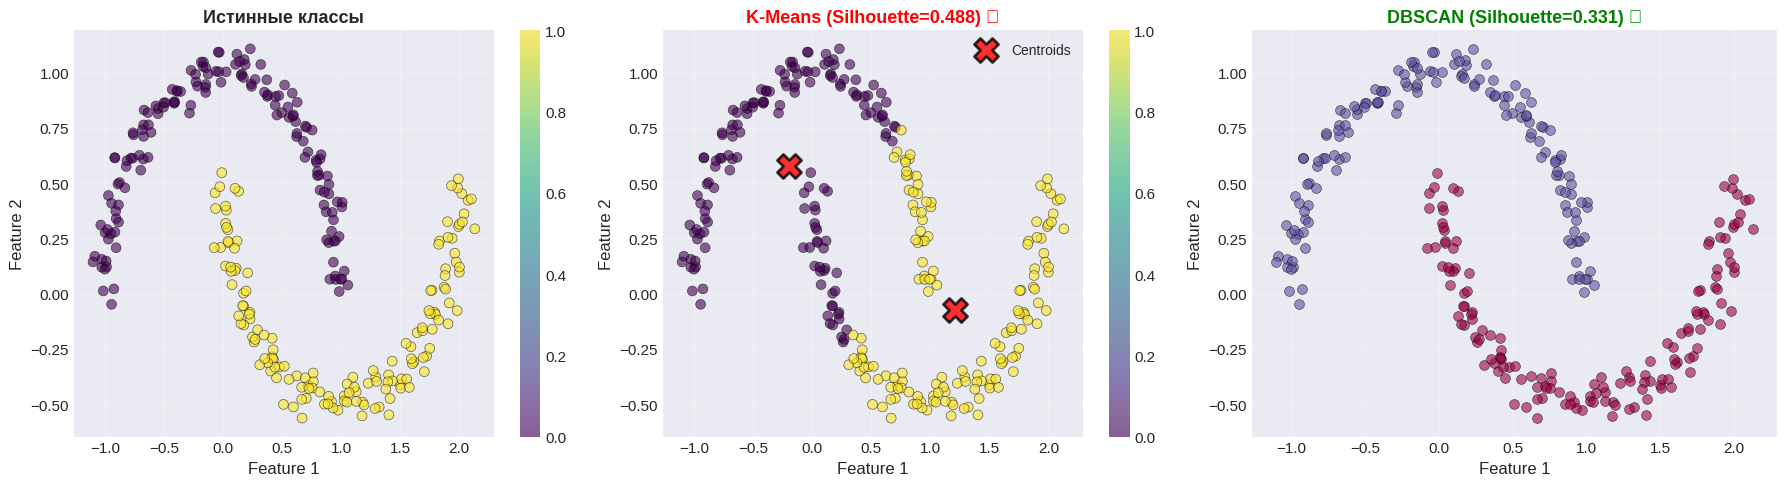


💡 K-Means не может найти кластеры произвольной формы
   DBSCAN отлично справляется с такими данными!

   Число кластеров DBSCAN: 2
   Число шумовых точек: 0


In [2]:
# Создаём данные в форме полумесяцев
np.random.seed(42)
X_moons, y_moons_true = make_moons(n_samples=300, noise=0.05, random_state=42)

print(f"📊 Данные: {X_moons.shape[0]} объектов")
print(f"   Истинные классы: {np.unique(y_moons_true)}")

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_moons)
sil_kmeans = silhouette_score(X_moons, labels_kmeans)

# DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_moons)
# Silhouette только для точек не являющихся шумом
mask = labels_dbscan != -1
if mask.sum() > 0:
    sil_dbscan = silhouette_score(X_moons[mask], labels_dbscan[mask])
else:
    sil_dbscan = -1

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Истинные классы
scatter1 = axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons_true, s=50,
                           cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Истинные классы', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# K-Means
scatter2 = axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_kmeans, s=50,
                           cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
centers = kmeans.cluster_centers_
axes[1].scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.8,
                marker='X', edgecolors='black', linewidth=2, label='Centroids')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title(f'K-Means (Silhouette={sil_kmeans:.3f}) ❌', fontsize=13, fontweight='bold', color='red')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1])

# DBSCAN
# Разные цвета для кластеров и шума
unique_labels = set(labels_dbscan)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Шум - чёрный
        col = [0, 0, 0, 1]
        marker = 'x'
        s_size = 30
    else:
        marker = 'o'
        s_size = 50

    class_member_mask = (labels_dbscan == k)
    xy = X_moons[class_member_mask]
    axes[2].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
                   alpha=0.6, edgecolors='black', linewidth=0.5)

axes[2].set_xlabel('Feature 1', fontsize=12)
axes[2].set_ylabel('Feature 2', fontsize=12)
axes[2].set_title(f'DBSCAN (Silhouette={sil_dbscan:.3f}) ✅', fontsize=13, fontweight='bold', color='green')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 K-Means не может найти кластеры произвольной формы")
print(f"   DBSCAN отлично справляется с такими данными!")
print(f"\n   Число кластеров DBSCAN: {len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)}")
print(f"   Число шумовых точек: {list(labels_dbscan).count(-1)}")

## 3. Базовый DBSCAN

In [3]:
# Создаём данные с выбросами
np.random.seed(42)
X_blobs, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)

# Добавляем выбросы
outliers = np.random.uniform(low=-10, high=10, size=(20, 2))
X = np.vstack([X_blobs, outliers])

print(f"📊 Данные: {X.shape[0]} объектов (300 нормальных + 20 выбросов)")

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Статистика
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
n_core = len(dbscan.core_sample_indices_)

print(f"\n🎯 Результаты DBSCAN (eps={dbscan.eps}, min_samples={dbscan.min_samples}):")
print(f"   Число кластеров: {n_clusters}")
print(f"   Число шумовых точек: {n_noise}")
print(f"   Число корневых точек: {n_core}")
print(f"   Число граничных точек: {len(X) - n_core - n_noise}")

📊 Данные: 320 объектов (300 нормальных + 20 выбросов)

🎯 Результаты DBSCAN (eps=0.5, min_samples=5):
   Число кластеров: 3
   Число шумовых точек: 21
   Число корневых точек: 290
   Число граничных точек: 9


/tmp/ipykernel_54573/52692485.py:16: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], s=80, marker='x',
/tmp/ipykernel_54573/52692485.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1].scatter(X[noise_mask, 0], X[noise_mask, 1],


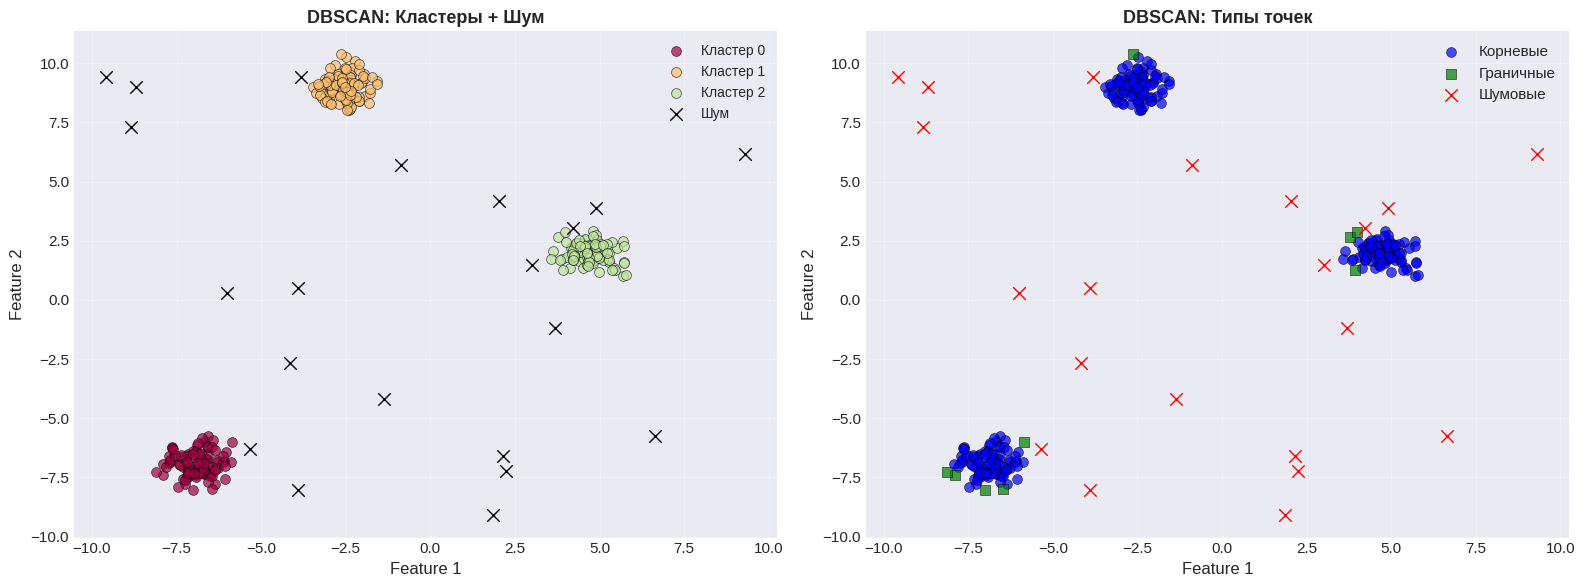


💡 DBSCAN автоматически выделил 3 кластера и обнаружил выбросы!


In [4]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Все точки с метками
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Чёрный для шума

    class_member_mask = (labels == k)
    xy = X[class_member_mask]

    if k == -1:
        axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], s=80, marker='x',
                       label='Шум', edgecolors='black', linewidth=1)
    else:
        axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], s=50, marker='o',
                       label=f'Кластер {k}', alpha=0.7, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('DBSCAN: Кластеры + Шум', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3)

# Типы точек: корневые, граничные, шумовые
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Корневые точки
axes[1].scatter(X[core_samples_mask, 0], X[core_samples_mask, 1],
                c='blue', s=50, marker='o', label='Корневые', alpha=0.7,
                edgecolors='black', linewidth=0.5)

# Граничные точки
border_mask = (labels != -1) & (~core_samples_mask)
axes[1].scatter(X[border_mask, 0], X[border_mask, 1],
                c='green', s=50, marker='s', label='Граничные', alpha=0.7,
                edgecolors='black', linewidth=0.5)

# Шумовые точки
noise_mask = (labels == -1)
axes[1].scatter(X[noise_mask, 0], X[noise_mask, 1],
                c='red', s=80, marker='x', label='Шумовые',
                edgecolors='black', linewidth=1)

axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('DBSCAN: Типы точек', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 DBSCAN автоматически выделил 3 кластера и обнаружил выбросы!")

## 4. Выбор параметра eps: k-distance graph

🔬 k-distance graph (k=5)
   Минимальное расстояние: 0.072
   Максимальное расстояние: 1.193
   Медианное расстояние: 0.188


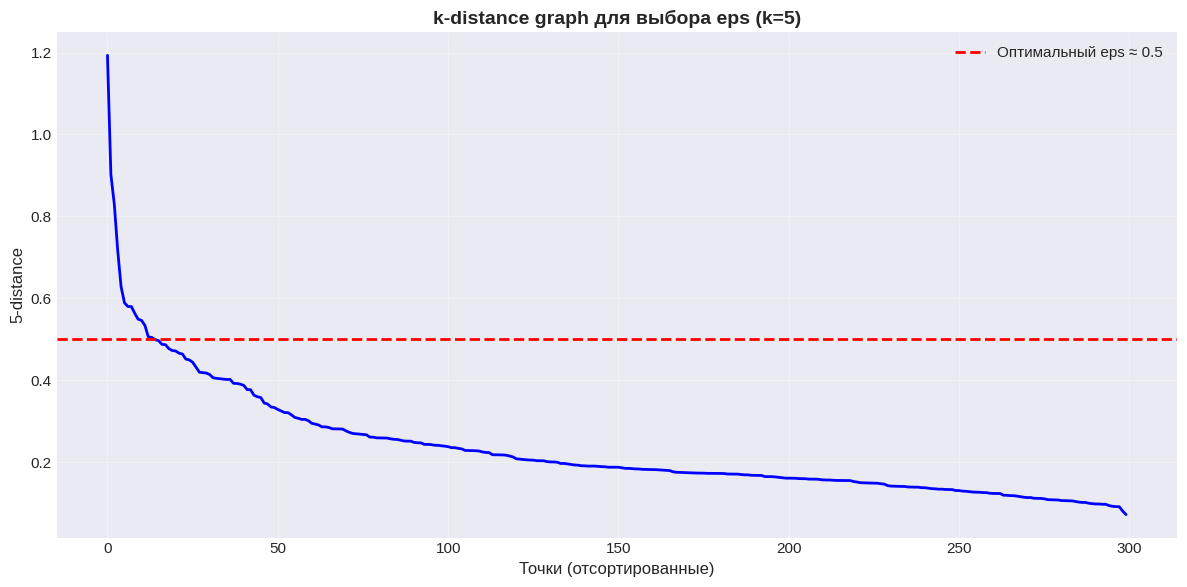


💡 'Локоть' на графике около eps=0.5 → оптимальное значение


In [5]:
# Используем данные X_blobs (без выбросов для наглядности)
np.random.seed(42)
X_sample, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)

# Вычисляем k-distance для каждой точки
k = 5  # min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_sample)
distances, indices = neighbors.kneighbors(X_sample)

# Берём расстояние до k-го соседа
k_distances = distances[:, -1]
k_distances_sorted = np.sort(k_distances)[::-1]

print(f"🔬 k-distance graph (k={k})")
print(f"   Минимальное расстояние: {k_distances_sorted[-1]:.3f}")
print(f"   Максимальное расстояние: {k_distances_sorted[0]:.3f}")
print(f"   Медианное расстояние: {np.median(k_distances_sorted):.3f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, 'b-', linewidth=2)
plt.xlabel('Точки (отсортированные)', fontsize=12)
plt.ylabel(f'{k}-distance', fontsize=12)
plt.title(f'k-distance graph для выбора eps (k={k})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Добавляем вертикальные линии для возможных eps
optimal_eps = 0.5  # визуально определяем локоть
plt.axhline(y=optimal_eps, color='red', linestyle='--', linewidth=2, label=f'Оптимальный eps ≈ {optimal_eps}')
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n💡 'Локоть' на графике около eps={optimal_eps} → оптимальное значение")

## 5. Влияние параметров eps и min_samples

/tmp/ipykernel_54573/2810568268.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[idx].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
/tmp/ipykernel_54573/2810568268.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[idx].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
/tmp/ipykernel_54573/2810568268.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[idx].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
/tmp/ipykernel_54573/2810568268.py:32: UserWarning: You passed a edgecolor/edgecol

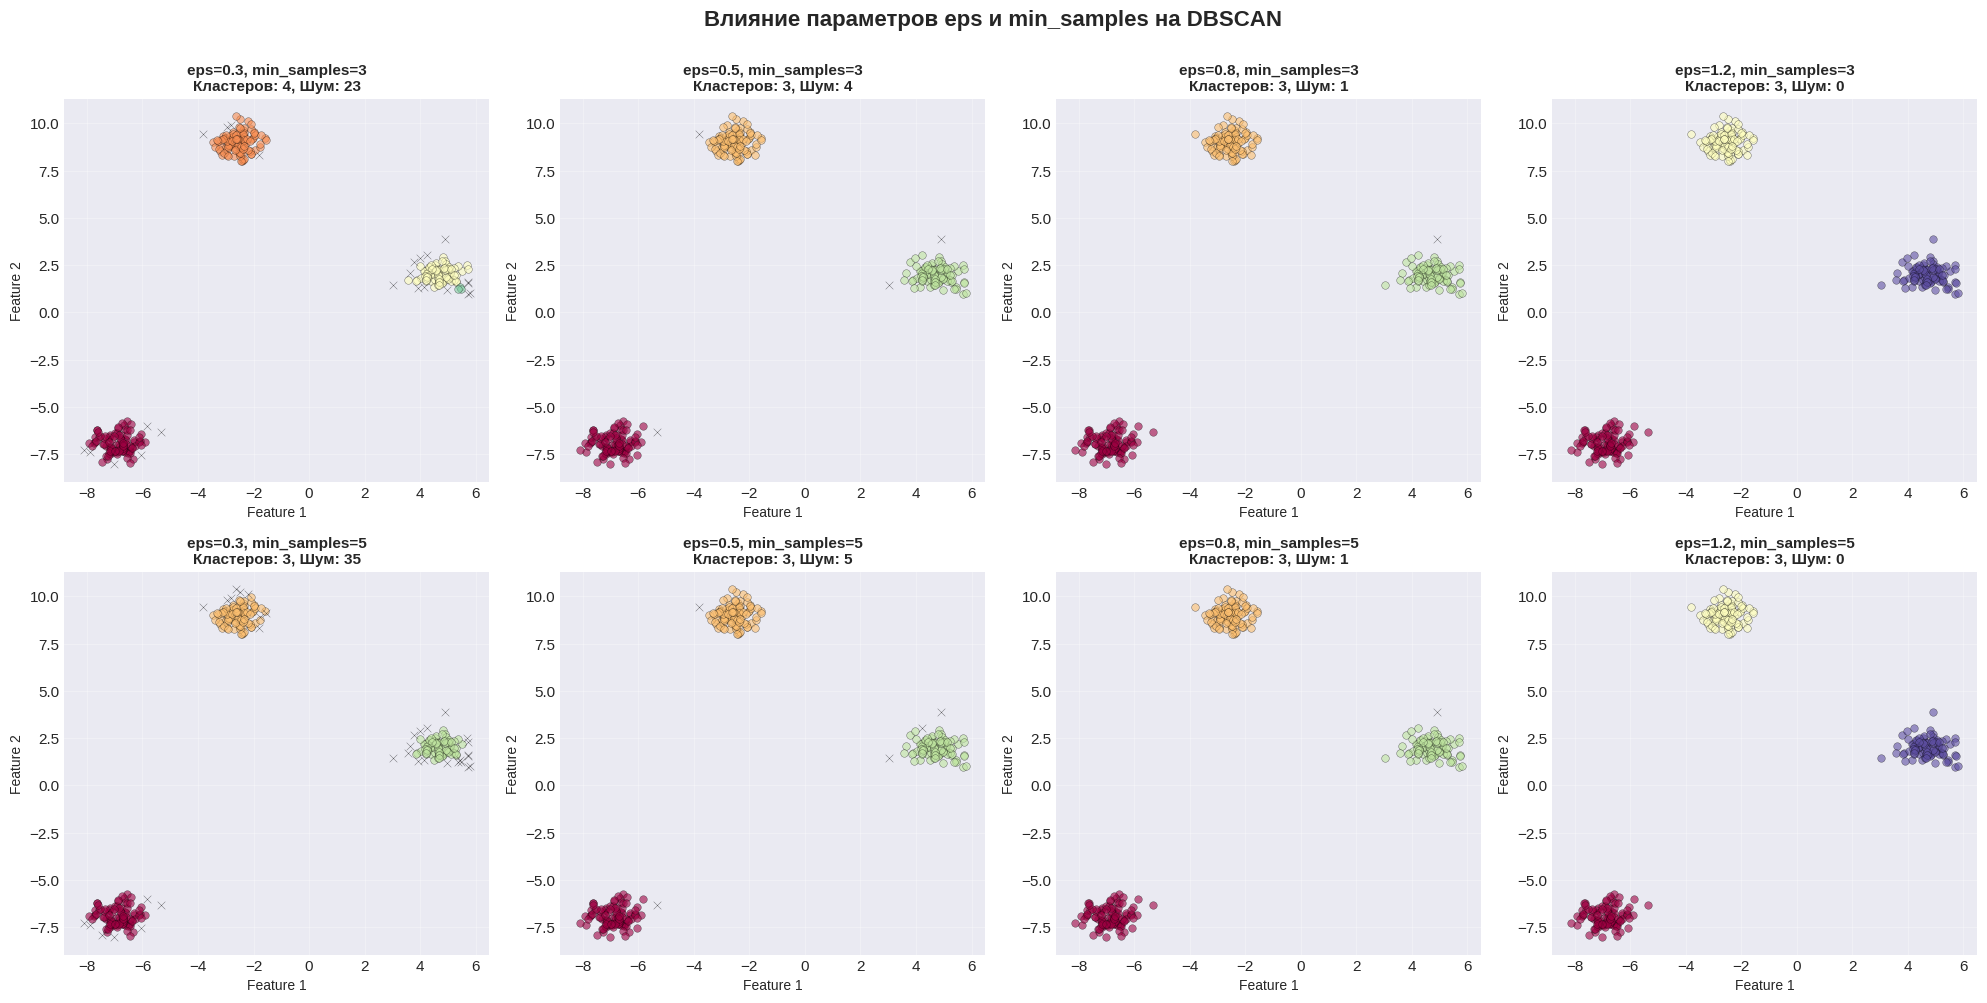


💡 Наблюдения:
   - Маленький eps → больше шума, больше мелких кластеров
   - Большой eps → меньше кластеров, всё объединяется
   - Маленький min_samples → меньше шума, больше кластеров
   - Большой min_samples → больше шума, строже критерий корневых точек


In [6]:
# Тестируем разные параметры
eps_values = [0.3, 0.5, 0.8, 1.2]
min_samples_values = [3, 5]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

idx = 0
for min_samp in min_samples_values:
    for eps_val in eps_values:
        dbscan_temp = DBSCAN(eps=eps_val, min_samples=min_samp)
        labels_temp = dbscan_temp.fit_predict(X_sample)

        n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
        n_noise_temp = list(labels_temp).count(-1)

        # Визуализация
        unique_labels = set(labels_temp)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = [0, 0, 0, 1]
                marker = 'x'
                s_size = 30
            else:
                marker = 'o'
                s_size = 30

            class_member_mask = (labels_temp == k)
            xy = X_sample[class_member_mask]
            axes[idx].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
                            alpha=0.6, edgecolors='black', linewidth=0.3)

        axes[idx].set_title(f'eps={eps_val}, min_samples={min_samp}\nКластеров: {n_clusters_temp}, Шум: {n_noise_temp}',
                           fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Feature 1', fontsize=10)
        axes[idx].set_ylabel('Feature 2', fontsize=10)
        axes[idx].grid(True, alpha=0.3)

        idx += 1

plt.suptitle('Влияние параметров eps и min_samples на DBSCAN', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Наблюдения:")
print("   - Маленький eps → больше шума, больше мелких кластеров")
print("   - Большой eps → меньше кластеров, всё объединяется")
print("   - Маленький min_samples → меньше шума, больше кластеров")
print("   - Большой min_samples → больше шума, строже критерий корневых точек")

## 6. Сравнение с K-Means на разных типах данных

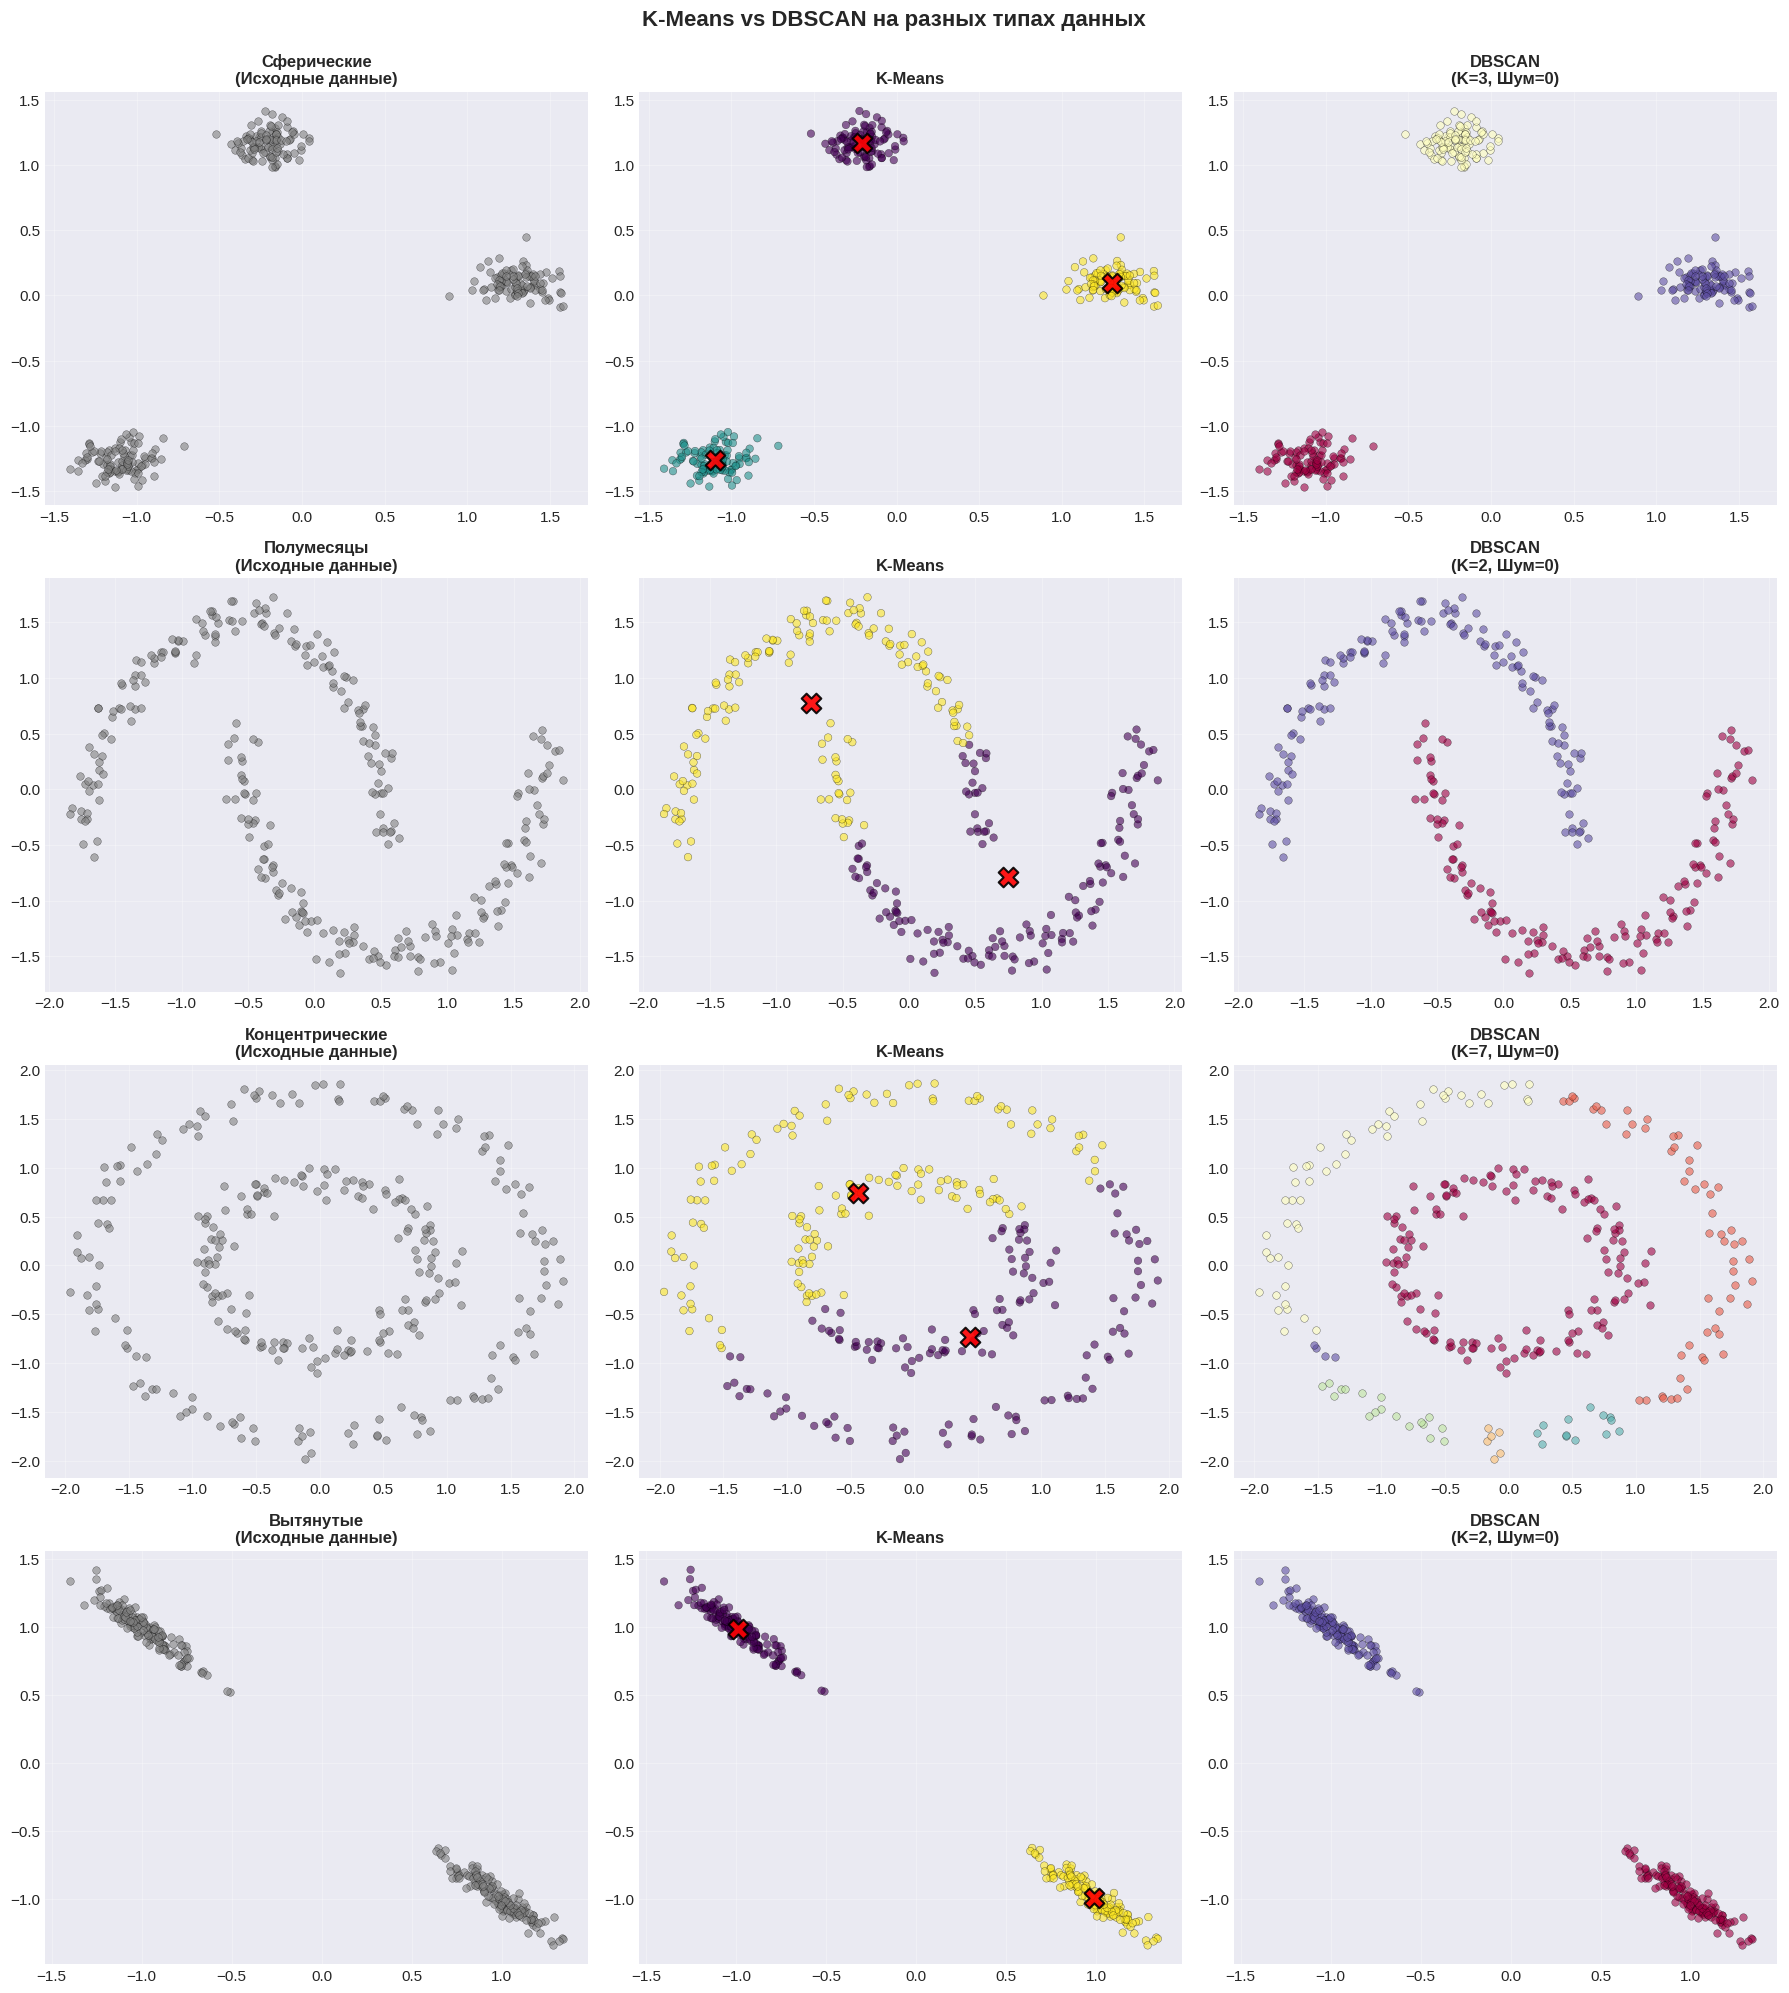


💡 Выводы:
   ✅ K-Means хорош для сферических кластеров
   ❌ K-Means плох для произвольных форм
   ✅ DBSCAN отлично работает с произвольными формами
   ✅ DBSCAN автоматически определяет число кластеров


In [7]:
# Создаём разные типы данных
np.random.seed(42)

# 1. Сферические кластеры
X1, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.6, random_state=42)

# 2. Полумесяцы
X2, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# 3. Концентрические круги
X3, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

# 4. Вытянутые кластеры
X4_blob, _ = make_blobs(n_samples=300, centers=2, cluster_std=0.8, random_state=42)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X4 = np.dot(X4_blob, transformation)

datasets = [X1, X2, X3, X4]
titles = ['Сферические', 'Полумесяцы', 'Концентрические', 'Вытянутые']

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for i, (X_data, title) in enumerate(zip(datasets, titles)):
    # Нормализация
    X_scaled = StandardScaler().fit_transform(X_data)

    # K-Means
    kmeans_temp = KMeans(n_clusters=2 if i != 0 else 3, random_state=42, n_init=10)
    labels_km = kmeans_temp.fit_predict(X_scaled)

    # DBSCAN
    eps_param = 0.3 if i == 0 else 0.25
    dbscan_temp = DBSCAN(eps=eps_param, min_samples=5)
    labels_db = dbscan_temp.fit_predict(X_scaled)

    # Исходные данные
    axes[i, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], s=30, alpha=0.6,
                       edgecolors='black', linewidth=0.3, c='gray')
    axes[i, 0].set_title(f'{title}\n(Исходные данные)', fontsize=12, fontweight='bold')
    axes[i, 0].grid(True, alpha=0.3)

    # K-Means
    scatter_km = axes[i, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_km,
                                    s=30, cmap='viridis', alpha=0.6,
                                    edgecolors='black', linewidth=0.3)
    centers_km = kmeans_temp.cluster_centers_
    axes[i, 1].scatter(centers_km[:, 0], centers_km[:, 1], c='red', s=200,
                       marker='X', edgecolors='black', linewidth=1.5, alpha=0.9)
    axes[i, 1].set_title('K-Means', fontsize=12, fontweight='bold')
    axes[i, 1].grid(True, alpha=0.3)

    # DBSCAN
    unique_labels = set(labels_db)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
            marker = 'x'
            s_size = 20
        else:
            marker = 'o'
            s_size = 30

        class_member_mask = (labels_db == k)
        xy = X_scaled[class_member_mask]
        axes[i, 2].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
                          alpha=0.6, edgecolors='black', linewidth=0.3)

    n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise_db = list(labels_db).count(-1)
    axes[i, 2].set_title(f'DBSCAN\n(K={n_clusters_db}, Шум={n_noise_db})',
                         fontsize=12, fontweight='bold')
    axes[i, 2].grid(True, alpha=0.3)

plt.suptitle('K-Means vs DBSCAN на разных типах данных', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Выводы:")
print("   ✅ K-Means хорош для сферических кластеров")
print("   ❌ K-Means плох для произвольных форм")
print("   ✅ DBSCAN отлично работает с произвольными формами")
print("   ✅ DBSCAN автоматически определяет число кластеров")

## 7. Обнаружение аномалий с DBSCAN

In [9]:
# Генерируем данные с аномалиями
np.random.seed(42)
X_normal, _ = make_blobs(n_samples=200, centers=2, cluster_std=0.5, random_state=42)

# Добавляем аномалии
anomalies = np.array([
    [-5, -5], [6, 6], [-6, 5], [5, -6],
    [7, -2], [-7, 2], [3, 7], [-3, -7]
])

X_with_anomalies = np.vstack([X_normal, anomalies])

print(f"📊 Данные: {X_normal.shape[0]} нормальных точек + {anomalies.shape[0]} аномалий")

# DBSCAN для обнаружения аномалий
dbscan_anomaly = DBSCAN(eps=0.5, min_samples=5)
labels_anomaly = dbscan_anomaly.fit_predict(X_with_anomalies)

# Статистика
n_clusters_anom = len(set(labels_anomaly)) - (1 if -1 in labels_anomaly else 0)
n_anomalies = list(labels_anomaly).count(-1)

print(f"\n🔍 Результаты обнаружения аномалий:")
print(f"   Число кластеров: {n_clusters_anom}")
print(f"   Обнаружено аномалий: {n_anomalies}")
print(f"   Истинное число аномалий: {anomalies.shape[0]}")
print(f"   Точность обнаружения: {n_anomalies / anomalies.shape[0] * 100:.1f}%")

📊 Данные: 200 нормальных точек + 8 аномалий

🔍 Результаты обнаружения аномалий:
   Число кластеров: 2
   Обнаружено аномалий: 12
   Истинное число аномалий: 8
   Точность обнаружения: 150.0%


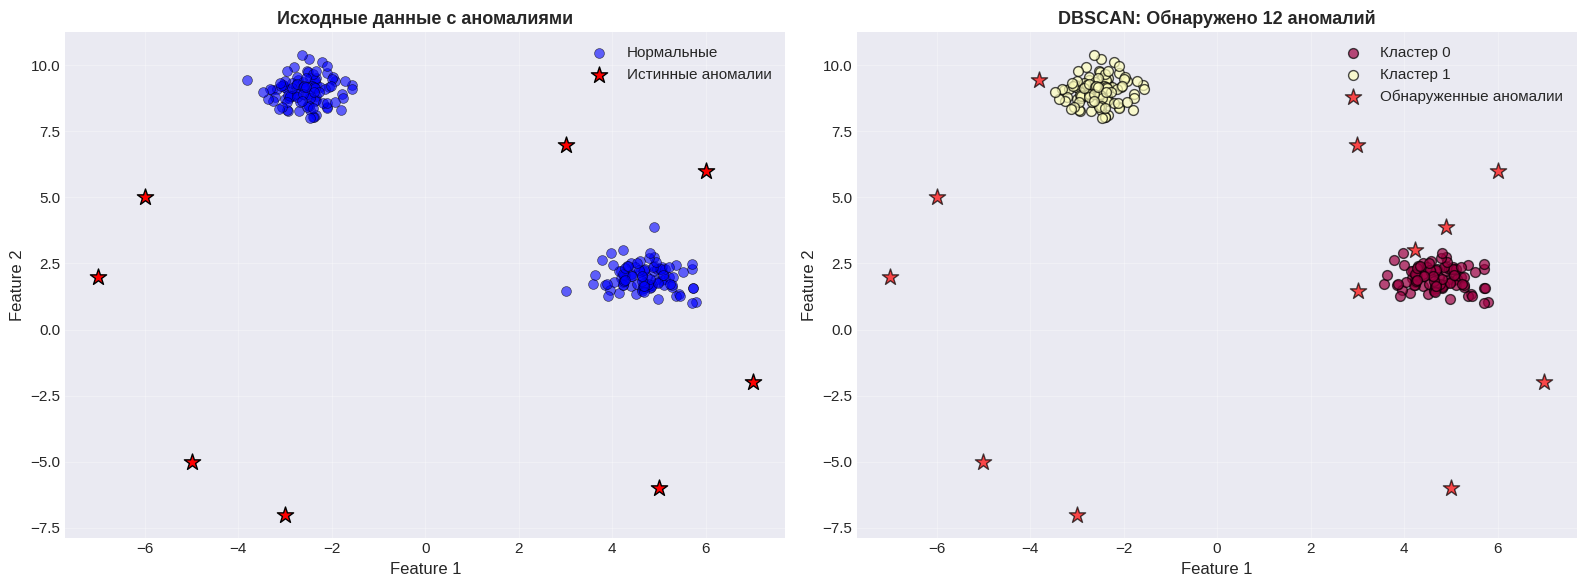


💡 DBSCAN можно использовать для обнаружения аномалий (outlier detection)!


In [10]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Исходные данные с истинными аномалиями
axes[0].scatter(X_normal[:, 0], X_normal[:, 1], s=50, c='blue', alpha=0.6,
                edgecolors='black', linewidth=0.5, label='Нормальные')
axes[0].scatter(anomalies[:, 0], anomalies[:, 1], s=150, c='red', marker='*',
                edgecolors='black', linewidth=1, label='Истинные аномалии')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Исходные данные с аномалиями', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# DBSCAN результат
unique_labels = set(labels_anomaly)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [1, 0, 0, 1]  # Красный для аномалий
        marker = '*'
        s_size = 150
        label_text = 'Обнаруженные аномалии'
    else:
        marker = 'o'
        s_size = 50
        label_text = f'Кластер {k}'

    class_member_mask = (labels_anomaly == k)
    xy = X_with_anomalies[class_member_mask]
    axes[1].scatter(xy[:, 0], xy[:, 1], c=[col], s=s_size, marker=marker,
                   alpha=0.7, edgecolors='black', linewidth=1, label=label_text)

axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title(f'DBSCAN: Обнаружено {n_anomalies} аномалий', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 DBSCAN можно использовать для обнаружения аномалий (outlier detection)!")